## Recommendations for Microsoft's New Movie Studio

####  In this notebook we are going to analyze the relationship between the movie success and movie time of release,movie runtime, movie genre, directors, and actors/actresses. Success will be based on ROI and Profit margin.

#### First objective is to clean up the movie budget dataframe, then merge all the relevant data sets.

In [2]:

#importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pyplot import figure
import sqlite3

In [3]:
ls

'#1 jbook stefano-Copy1.ipynb'   im.db.zip              rt.reviews.tsv.gz
 bom.movie_gross.csv.gz          jbook_Samuel.ipynb     tmdb.movies.csv.gz
 im.db                           rt.movie_info.tsv.gz   tn.movie_budgets.csv.gz


In [4]:
conn = sqlite3.connect('im.db')

In [5]:
funds = pd.read_csv('tn.movie_budgets.csv.gz')

In [6]:
pd.read_sql("""

SELECT *

FROM sqlite_master

""", conn)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [7]:
#copy df to work on, do not overwrite orignal 
numbers = funds.copy()



#funtion for cleaning
def clean_a_money_column(df, series_title):
    df[series_title] = df[series_title].str.replace('$','')
    df[series_title] = df[series_title].str.replace(',','')
    df[series_title] = pd.to_numeric(df[series_title])
    return df



#remove $ string
numbers = clean_a_money_column(numbers,'worldwide_gross')
numbers = clean_a_money_column(numbers,'domestic_gross')
numbers = clean_a_money_column(numbers,'production_budget')



# new column foreign_gross, Profit Margin, ROI
numbers['net_income'] = numbers['worldwide_gross'] - numbers['production_budget']
numbers['foreign_gross'] = numbers['worldwide_gross'] - numbers['domestic_gross']
numbers['Profit Margin'] = (numbers['net_income']*100)/numbers['worldwide_gross']
numbers.loc[numbers['Profit Margin'] == float('-inf'), 'Profit Margin'] = 0
numbers['ROI'] = (numbers['net_income']) / numbers['production_budget'] * 100


# new columns month and year 
numbers['Year'] = pd.to_numeric(numbers['release_date'].map(lambda x: x[-4:]))
numbers['Month'] = numbers['release_date'].map(lambda x: x[:3])



#check for dupes
movie_dupes = pd.Series(numbers['movie'].value_counts())
title_dupes = [movie_dupes.index[index] for index in list(range(len(movie_dupes))) if movie_dupes.values[index] > 1]
numbers[numbers['movie'].isin(title_dupes)]

numbers


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,net_income,foreign_gross,Profit Margin,ROI,Year,Month
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,2015837654,84.692106,553.257713,2009,Dec
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,804600000,60.733080,154.667286,2011,May
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,107000000,-133.703598,-57.210757,2019,Jun
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,944008095,76.436443,324.384139,2015,May
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747,696540365,75.925058,315.369636,2017,Dec
...,...,...,...,...,...,...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,7000,0,0,-7000,0,0.000000,-100.000000,2018,Dec
5778,79,"Apr 2, 1999",Following,6000,48482,240495,234495,192013,97.505146,3908.250000,1999,Apr
5779,80,"Jul 13, 2005",Return to the Land of Wonders,5000,1338,1338,-3662,0,-273.692078,-73.240000,2005,Jul
5780,81,"Sep 29, 2015",A Plague So Pleasant,1400,0,0,-1400,0,0.000000,-100.000000,2015,Sep


# Reading in IMDB's title.basics dataset

In [8]:
genetime = pd.read_sql("""

SELECT primary_title as movie, start_year as year, runtime_minutes, genres
FROM

movie_basics

""", conn)

genetime

,movie,year,runtime_minutes,genres
0,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,One Day Before the Rainy Season,2019,114.0,"Biography,Drama"
2,The Other Side of the Wind,2018,122.0,Drama
3,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...
146139,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,Dankyavar Danka,2013,NaN,Comedy
146142,6 Gunn,2017,116.0,None


In [9]:
pd.read_sql("""

SELECT *

FROM 


""", conn)

DatabaseError: Execution failed on sql '

SELECT *

FROM 


': incomplete input

In [10]:
supe = numbers.merge(genetime)
supe

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,net_income,foreign_gross,Profit Margin,ROI,Year,Month,year,runtime_minutes,genres
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,2015837654,84.692106,553.257713,2009,Dec,2011,93.0,Horror
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,804600000,60.733080,154.667286,2011,May,2011,136.0,"Action,Adventure,Fantasy"
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,107000000,-133.703598,-57.210757,2019,Jun,2019,113.0,"Action,Adventure,Sci-Fi"
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,944008095,76.436443,324.384139,2015,May,2015,141.0,"Action,Adventure,Sci-Fi"
4,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200,1369318718,85.352522,582.711400,2018,Apr,2018,149.0,"Action,Adventure,Sci-Fi"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3810,68,"Jul 6, 2001",Cure,10000,94596,94596,84596,0,89.428728,845.960000,2001,Jul,2014,NaN,None
3811,70,"Apr 1, 1996",Bang,10000,527,527,-9473,0,-1797.533207,-94.730000,1996,Apr,2015,NaN,None
3812,73,"Jan 13, 2012",Newlyweds,9000,4584,4584,-4416,0,-96.335079,-49.066667,2012,Jan,2011,95.0,"Comedy,Drama"
3813,78,"Dec 31, 2018",Red 11,7000,0,0,-7000,0,0.000000,-100.000000,2018,Dec,2019,77.0,"Horror,Sci-Fi,Thriller"


In [11]:
supe.isna().sum()

id                     0
release_date           0
movie                  0
production_budget      0
domestic_gross         0
worldwide_gross        0
net_income             0
foreign_gross          0
Profit Margin          0
ROI                    0
Year                   0
Month                  0
year                   0
runtime_minutes      487
genres                72
dtype: int64

In [12]:
huey = supe.dropna(subset=['runtime_minutes', 'genres'])
huey.isna().sum()


id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
net_income           0
foreign_gross        0
Profit Margin        0
ROI                  0
Year                 0
Month                0
year                 0
runtime_minutes      0
genres               0
dtype: int64

KeyError: 2776345279

In [13]:
runmean = jon['runtime_minutes'].mean()
runmean

NameError: name 'jon' is not defined

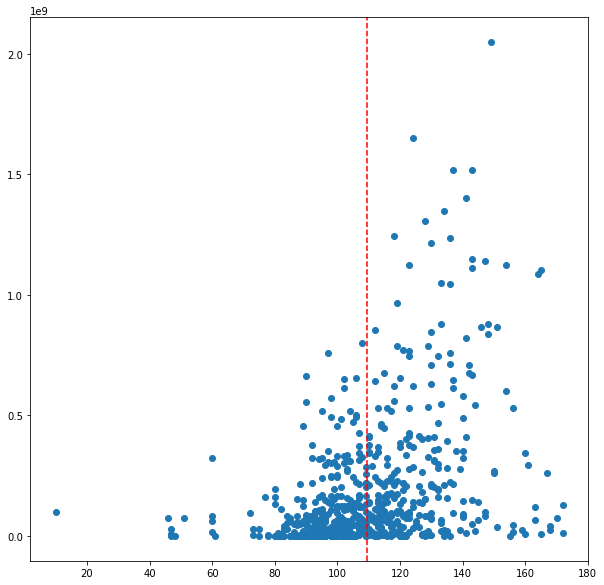

In [55]:
def genegraph(gene):
    jon = huey.loc[huey['genres'].str.contains(gene)]
    fig, ax = plt.subplots(figsize=(10,10))
    x = jon['runtime_minutes']
    y = jon['worldwide_gross']
    ax.scatter(x,y)
    ax.axvline(x.mean(), label='Median', linestyle='--', color= 'Red')
genegraph('Action')

In [158]:
gs = []
genlist = huey['genres'].str.split(',')

for things in genlist:
    gs.extend(things)
ugs = set(gs)
ugs

list(ugs)


['Fantasy',
 'Crime',
 'Animation',
 'History',
 'Horror',
 'Romance',
 'Western',
 'Reality-TV',
 'Action',
 'Thriller',
 'Drama',
 'Adventure',
 'News',
 'Musical',
 'Comedy',
 'Sport',
 'Documentary',
 'Music',
 'Family',
 'War',
 'Sci-Fi',
 'Biography',
 'Mystery']

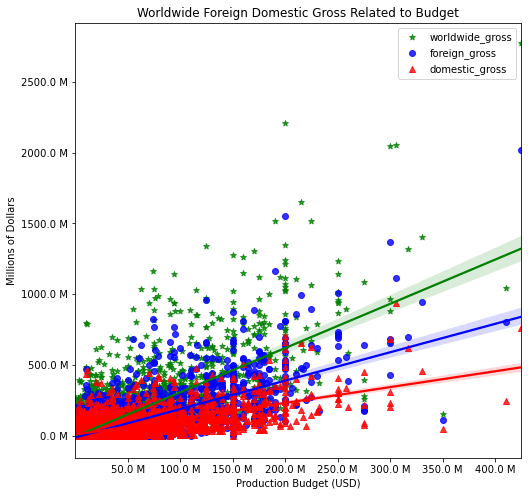

In [191]:
 'Worldwide & Domestic Gross Related to Production Budget',
# set up figure convert to millions
def million_formatter(x, pos):
    return "%.1f M" % (x/1E6)
fig, ax = plt.subplots(figsize=(8,8), sharey=True)
# green dots/line will be ww gross as a function of production_budget
ax1 = sns.regplot(data=numbers, x='production_budget',
                 y='worldwide_gross', color='green',marker='*', label='worldwide_gross')
# blue dots/line will be foreign_gross gross as a function of production_budget
ax2 = sns.regplot(data=numbers, x='production_budget',
                 y='foreign_gross', color='blue',marker='o', label='foreign_gross')
# red dots/line will be domestic_gross as a function of production_budget
ax2 = sns.regplot(data=numbers, x='production_budget',
                 y='domestic_gross', color='red',marker='^', label='domestic_gross')
# include a legend
ax.legend()
# set title and axis labels
ax.set(title='Worldwide Foreign Domestic Gross Related to Budget',
      xlabel='Production Budget (USD)',
      ylabel = 'Millions of Dollars')
ax.xaxis.set_major_formatter(million_formatter)
ax.yaxis.set_major_formatter(million_formatter)

# Genre Data Exploration 

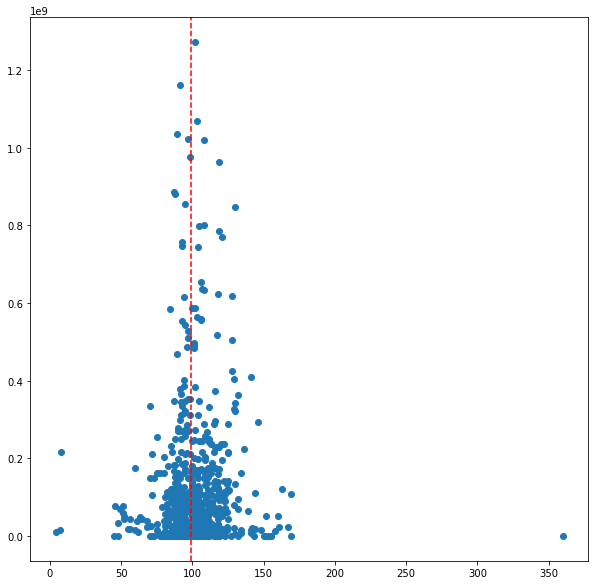

In [45]:
genegraph('Comedy')

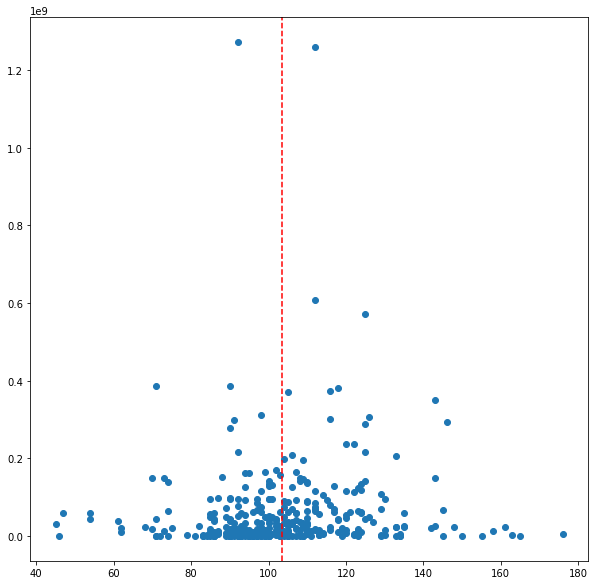

In [57]:
genegraph('Romance')

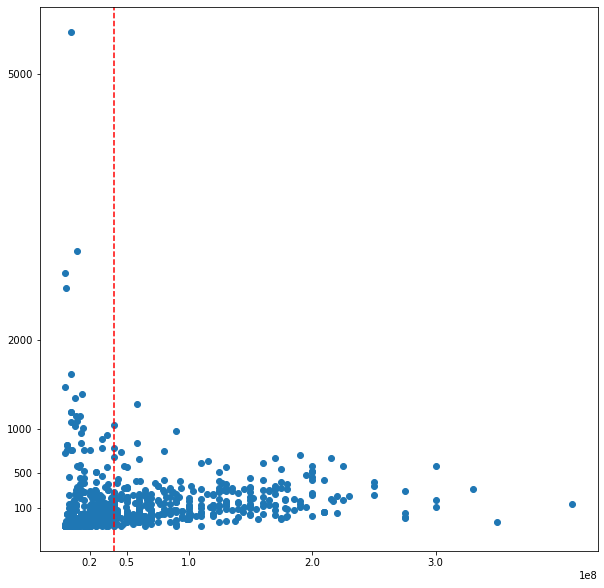

In [125]:
def genebudget(gene):
    top_sort = huey.sort_values(by=['ROI'], ascending=False)[40:]
    jon = top_sort.loc[top_sort['genres'].str.contains(gene)]
    fig, ax = plt.subplots(figsize=(10,10))
    y = jon['ROI']
    x = jon['production_budget']
    ax.scatter(x,y)
    ax.set_yticks([100, 500, 1000, 2000, 5000])
    ax.set_xticks([20000000, 50000000, 100000000, 200000000, 300000000])
    ax.axvline(x.median(), label='Median', linestyle='--', color= 'Red')
genebudget('Action')
    

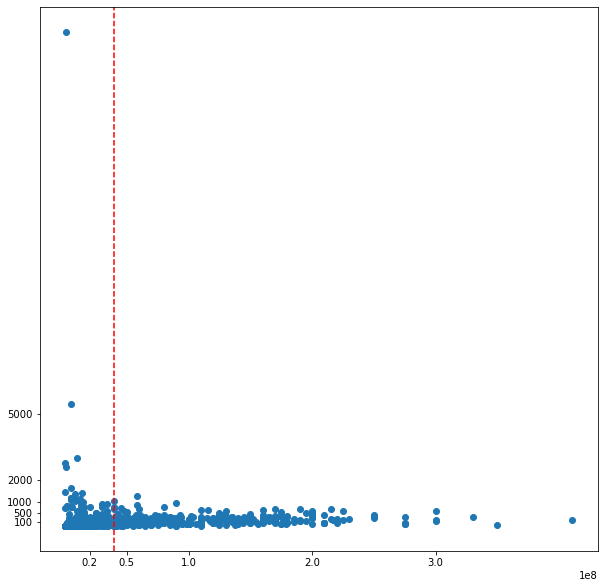

In [111]:
genebudget('Action')